Number of images:  7494


<function matplotlib.pyplot.show(*args, **kw)>

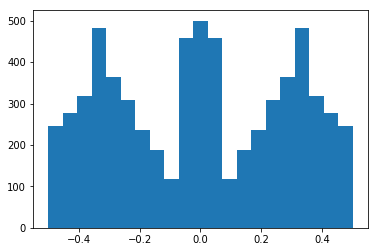

In [22]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = []
measurements = []

# Select which datasets to use for training
# Thought about making this automatic, but wanted ability to select individual datasets
datasets = ['Train4']#, 'Train2', 'Train4', 'Train5']


# Loop thorugh selected datasets
for dataset in datasets:
    lines = []
    with open('data/' + dataset + '_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    # Center, Left, Right
    steer_correct = [0, 0.04, -0.04]
    for line in lines:
        for i in range(3): #center, left, right
            sourcepath = line[i]
            filename = sourcepath.split('/')[-1]
            currentpath = 'data/' + dataset + '/' + filename
            image = cv2.imread(currentpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) # Suggested by nvidia
            images.append(image)
            images.append(cv2.flip(image,1)) #Flip image
            measurement = float(line[3]) + steer_correct[i]
            measurements.append(measurement)
            measurements.append(-measurement)
            
X_train_raw = np.array(images)
y_train_raw = np.array(measurements)

print("Number of images: ", len(y_train_raw))

plt.figure()
plt.hist(y_train_raw, bins=21, range=(-0.5, 0.5))
plt.show

(1310, 160, 320, 3)
(437, 160, 320, 3)
(7494, 160, 320, 3)
(6621, 160, 320, 3)


<function matplotlib.pyplot.show(*args, **kw)>

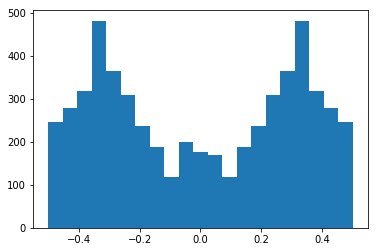

In [24]:
# Filter data - need to move this before data/steering augmentation...
steer_angle_thresh = 0.05
X_train = X_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]
y_train = y_train_raw[(y_train_raw <= -steer_angle_thresh) | (y_train_raw >= steer_angle_thresh)]

X_train_straight = X_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]
y_train_straight = y_train_raw[(y_train_raw > -steer_angle_thresh) & (y_train_raw < steer_angle_thresh)]

print (X_train_straight.shape)
# Grab 33% of straight data
X_train_straight = X_train_straight[np.arange(0, len(y_train_straight)-1, 3)]
y_train_straight = y_train_straight[np.arange(0, len(y_train_straight)-1, 3)]

print (X_train_straight.shape)

X_train = np.append(X_train, X_train_straight, axis=0)
y_train = np.append(y_train, y_train_straight, axis=0)

print(X_train_raw.shape)
print(X_train.shape)

plt.figure()
plt.hist(y_train, bins=21, range=(-0.5, 0.5))
plt.show


In [25]:
## Set Up NNs ##
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, MaxPooling2D, Dropout


dropout = [0.0, 0.3, 0.3, 0.5]


def LeNet1():
	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(10, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Convolution2D(20, 5, 5, activation='relu'))
	model.add(MaxPooling2D())
	model.add(Flatten())
	model.add(Dense(120))
	model.add(Dense(84))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7, batch_size=128)

	model.save('model.h5')

def nvidia():

	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#78x158
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#37x77
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#16x36
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 5, 5, subsample=(2,2), activation='relu'))#2x17
	model.add(Dropout(dropout[1]))
	#model.add(Convolution2D(64, 5, 5, subsample=(2,1), activation='relu'))#1x12
	model.add(Flatten())
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=128)

	model.save('model.h5')



def nvidia2(): # Same sizes and convoltuions as NVIDIA network

	model = Sequential()
	model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
	# Crop to a 3 to 1 aspect ratio and then convert to 66x200
	model.add(Lambda(lambda x:(x/255.0)-0.5))
	model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))#31x98
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))#14X47
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))#5x22
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#3x20
	model.add(Dropout(dropout[1]))
	model.add(Convolution2D(64, 3, 3, subsample=(1,1), activation='relu'))#1x18
	model.add(Flatten()) # May not need this
	model.add(Dense(1000))
	model.add(Dropout(dropout[3]))
	model.add(Dense(100))
	model.add(Dense(50))
	model.add(Dense(1))

	model.compile(loss = 'mse', optimizer = 'adam')
	model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3, batch_size=256)

	model.save('model.h5')


nvidia()

Train on 5296 samples, validate on 1325 samples
Epoch 1/3
1536/5296 [=======>......................] - ETA: 91s - loss: 0.2959


KeyboardInterrupt

